<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_analise_por_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Análise por local

In [ ]:
# Instalar pt_BR
!/usr/share/locales/install-language-pack pt_BR
!dpkg-reconfigure locales

import os

# Reiniciar o Python
os.kill(os.getpid(), 9)

# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

import datetime, locale, random

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi']     = 100

sns.set_style("darkgrid")

locale.setlocale(locale.LC_ALL, 'pt_BR')

PALETA = 'tab20'
CORES  = [plt.get_cmap(PALETA)(i) for i in (0, 8, 4, 2, 6)]

XLIM = [datetime.date(2020, 12, 25), datetime.date(2023, 3, 1)]

EVOLUCOES = {1: 'Cura',
             2: 'Óbito',
             3: 'Óbito por outras causas'}

# Dados

In [3]:
df_locais                        = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_locais.csv')
df_demora_por_municipio          = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_demora_por_municipio.csv', parse_dates=['Segunda-feira'])
df_evolucao_prisin_por_municipio = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_evolucao_prisin_por_municipio.csv', parse_dates=['Segunda-feira'])
df_sintomas_semana_por_municipio = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_sintomas_semana_por_municipio.zip', parse_dates=['Segunda-feira'])
df_cura_obito_por_municipio      = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_cura_obito_por_municipio.csv', parse_dates=['Segunda-feira'])

In [4]:
uf_codigo, uf_nome, mu_codigo, mu_nome = df_locais.sample().values[0]

if(random.getrandbits(1)):
    uf    = True
    local = f"\n{uf_codigo} - {uf_nome}"
else:
    uf    = False
    local = f"\n{mu_codigo} - {mu_nome} ({uf_codigo})"

# uf_codigo, uf_nome, mu_codigo, mu_nome = df_locais[df_locais['Municipio_Codigo'] == 354330].sample().values[0]
# uf, local = False, f"\n{mu_codigo} - {mu_nome} ({uf_codigo})"

# Análise

## Diferença média de dias entre primeiros sintomas e notificação

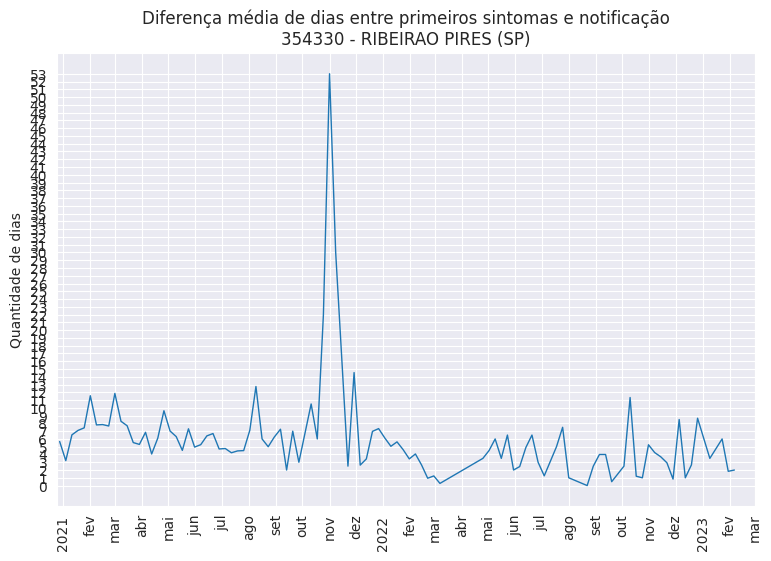

In [5]:
filtro = (df_demora_por_municipio['UF_Codigo'] == uf_codigo) if uf else (df_demora_por_municipio['Municipio_Codigo'] == mu_codigo)
dados  = df_demora_por_municipio[['Segunda-feira', 'Dias']][filtro].groupby(by=['Segunda-feira']).mean().reset_index()

ax = sns.lineplot(data=dados, x='Segunda-feira', y='Dias', linewidth=1, color=CORES[0])

plt.title(f'Diferença média de dias entre primeiros sintomas e notificação{local}')
plt.xlabel('')
plt.ylabel('Quantidade de dias')

plt.xlim(XLIM)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

for tick in ax.get_xticklabels(which='both'):
    tick.set_rotation(90)

plt.yticks(range(int(np.ceil(dados['Dias'].max() + 1))))

plt.grid(visible=True, which='both', axis='both');

## Evoluções por semana de primeiros sintomas

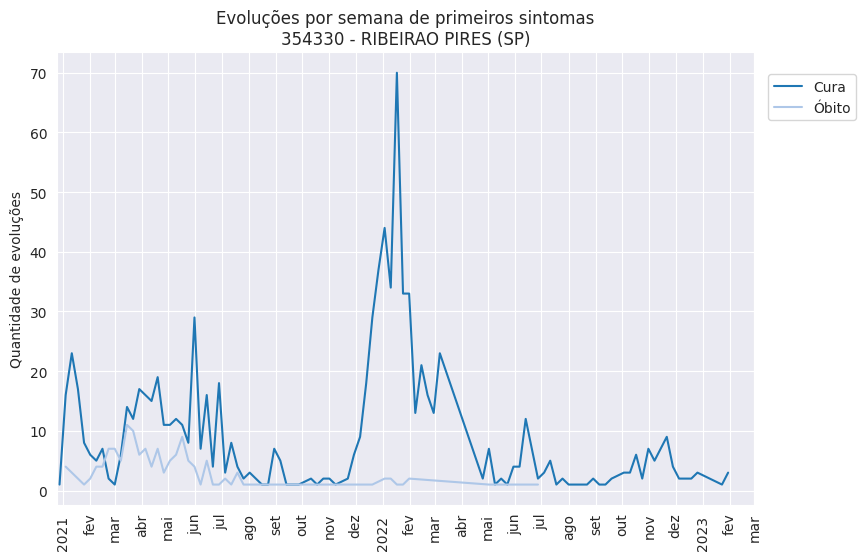

In [6]:
filtro = (df_evolucao_prisin_por_municipio['UF_Codigo'] == uf_codigo) if uf else (df_evolucao_prisin_por_municipio['Municipio_Codigo'] == mu_codigo)
dados  = df_evolucao_prisin_por_municipio[['Segunda-feira', 'Evolucao', 'Quantidade']][filtro].groupby(by=['Segunda-feira', 'Evolucao']).sum().sort_index().reset_index()

ax = sns.lineplot(data=dados, x='Segunda-feira', y='Quantidade', hue='Evolucao', palette=PALETA)

plt.title(f'Evoluções por semana de primeiros sintomas{local}')
plt.xlabel('')
plt.ylabel('Quantidade de evoluções')

plt.xlim(XLIM)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

for tick in ax.get_xticklabels(which='both'):
    tick.set_rotation(90)

plt.grid(visible=True, which='both', axis='both')

handles, _ = ax.get_legend_handles_labels()

plt.legend(loc=(1.02, 0.85), frameon=True, facecolor='white', handles=handles, labels=EVOLUCOES.values());

## Presença de sintomas em notificações por semana

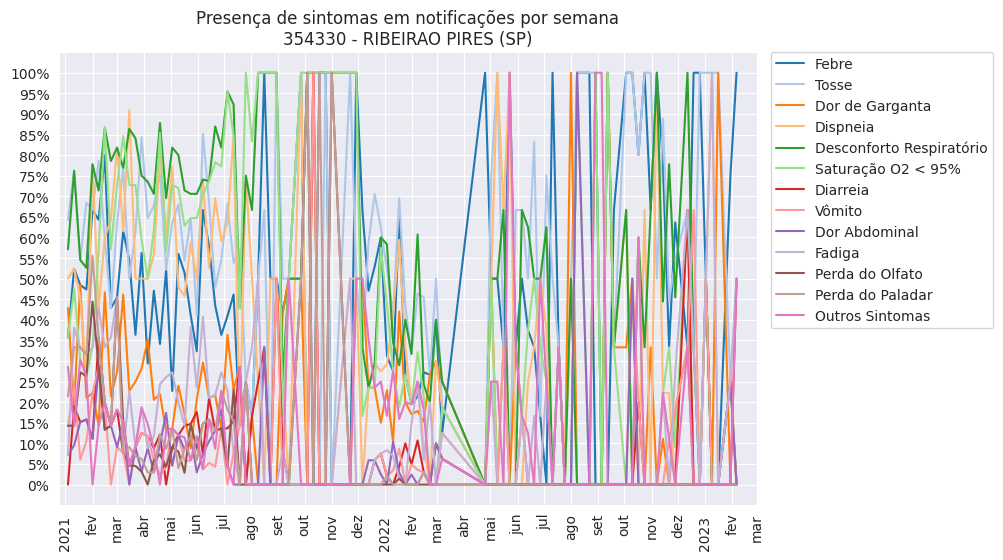

In [7]:
filtro = (df_sintomas_semana_por_municipio['UF_Codigo'] == uf_codigo) if uf else (df_sintomas_semana_por_municipio['Municipio_Codigo'] == mu_codigo)
dados  = df_sintomas_semana_por_municipio[['Segunda-feira', 'Sintoma', 'Presença']][filtro].groupby(by=['Segunda-feira', 'Sintoma']).mean().reset_index()

campos = ['Febre', 'Tosse', 'Dor de Garganta', 'Dispneia', 'Desconforto Respiratório', 'Saturação O2 < 95%',
          'Diarreia', 'Vômito', 'Dor Abdominal', 'Fadiga', 'Perda do Olfato', 'Perda do Paladar', 'Outros Sintomas']

dados['Sintoma'] = pd.Categorical(dados['Sintoma'], campos)

dados = dados.sort_values(['Segunda-feira', 'Sintoma']).reset_index(drop=True)

ax = sns.lineplot(data=dados, x='Segunda-feira', y='Presença', hue='Sintoma', palette=PALETA)

plt.title(f'Presença de sintomas em notificações por semana{local}')
plt.xlabel('')
plt.ylabel('')

plt.xlim(XLIM)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

for tick in ax.get_xticklabels(which='both'):
    tick.set_rotation(90)

ytick_step = 0.05
yticks     = np.arange(0, np.ceil((dados['Presença'].max() + ytick_step) / ytick_step) * ytick_step, ytick_step)

plt.yticks(ticks=yticks, labels=[f'{int(t * 100)}%' for t in yticks])

plt.grid(visible=True, which='both', axis='both')

plt.legend(loc=(1.02, 0.39), frameon=True, facecolor='white');

## Proporção de curas por óbitos por COVID-19

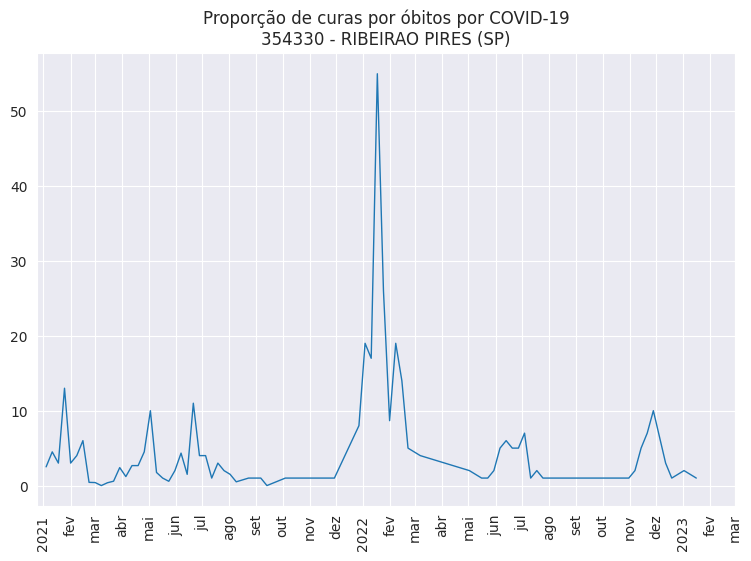

In [8]:
filtro = (df_cura_obito_por_municipio['UF_Codigo'] == uf_codigo) if uf else (df_cura_obito_por_municipio['Municipio_Codigo'] == mu_codigo)
dados  = df_cura_obito_por_municipio[['Segunda-feira', 'Proporcao']][filtro].groupby(by=['Segunda-feira']).mean().reset_index()

ax = sns.lineplot(data=dados, x='Segunda-feira', y='Proporcao', linewidth=1, color=CORES[0])

plt.title(f'Proporção de curas por óbitos por COVID-19{local}')
plt.xlabel('')
plt.ylabel('')

plt.xlim(XLIM)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

for tick in ax.get_xticklabels(which='both'):
    tick.set_rotation(90)

plt.grid(visible=True, which='both', axis='both');